In [2]:
import numpy as np 
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools
from scipy.spatial import distance
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas as pd

In [3]:
input_sdf = '/groups/idd/GIT_REPOS/graphpredict2/recommended_models/CYP3A4M_ALL-pIC50-2/train_data/cyp3a4_all_update_train.sdf'

In [4]:
df = PandasTools.LoadSDF(input_sdf)
#df = pd.read_csv("cyp3a4_all_update_train.csv")

In [16]:
df['CYP3A4_pIC50'] = df['CYP3A4_pIC50'].astype('float')

In [7]:
df['SMILES'] = [ Chem.MolToSmiles(s) for s in df['ROMol']]

(array([2.8000e+01, 2.4096e+04, 1.2634e+04, 3.2850e+03, 2.2150e+03,
        2.4770e+03, 5.4700e+02, 2.4300e+02, 4.2000e+01, 9.0000e+00]),
 array([3.98296666, 4.36137038, 4.73977411, 5.11817783, 5.49658155,
        5.87498528, 6.253389  , 6.63179272, 7.01019644, 7.38860017,
        7.76700389]),
 <BarContainer object of 10 artists>)

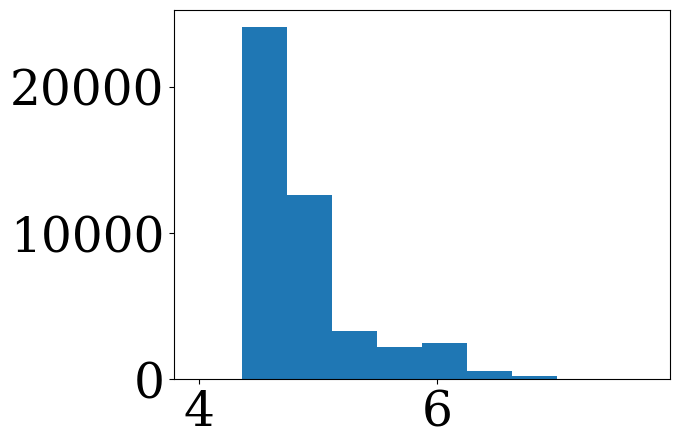

In [17]:
plt.hist(df['CYP3A4_pIC50'])

In [18]:
y = []
smiles = []
for i, s in enumerate(df.SMILES):
    try:
        smiles.append(s)
        y.append(df['CYP3A4_pIC50'][i])
    except:
        pass

In [19]:
fps_generated = []
for s in np.array(smiles):
    mol = Chem.MolFromSmiles(s)
    fps_generated.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
fps_generated = np.array(fps_generated)
y = np.array(y)

In [20]:
thresholds = []
baselines = []
global_probas = []
global_similarities = []
# Get smiles/label train and test 
similarities = []
properties = []
properties_1 = []
properties_2 = []
delta_property = []
X_test = fps_generated
y_test = y
indices = range(X_test.shape[0])
for index in np.random.choice(indices, 10000):
    fp = X_test[index, :]
    for index_other in np.random.choice(indices, 5000):
        fp_other = X_test[index_other, :]
        sim = 1 - distance.jaccard(fp, fp_other)
        similarities.append(sim)
        properties_1.append(y[index])
        properties_2.append(y[index_other])
        delta_property.append(np.abs(y[index]-y[index_other]))

delta_property = np.array(delta_property)
similarities = np.array(similarities)
probas = []

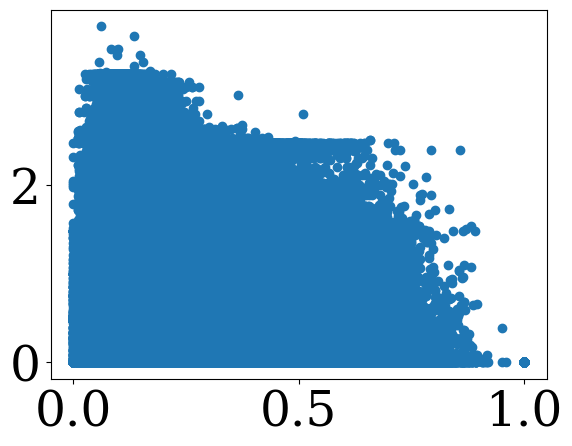

In [22]:
plt.scatter(similarities, delta_property)

In [23]:
global_probas = []
for step in np.linspace(0, 0.9, 6)[:-1]:
    X = []
    Y = []
    for i, sim in enumerate(similarities):
        if sim > step and sim <= step + 0.1:
            X.append(properties_1[i])
            Y.append(properties_2[i])
    global_probas.append(np.corrcoef([X, Y])[0, 1])

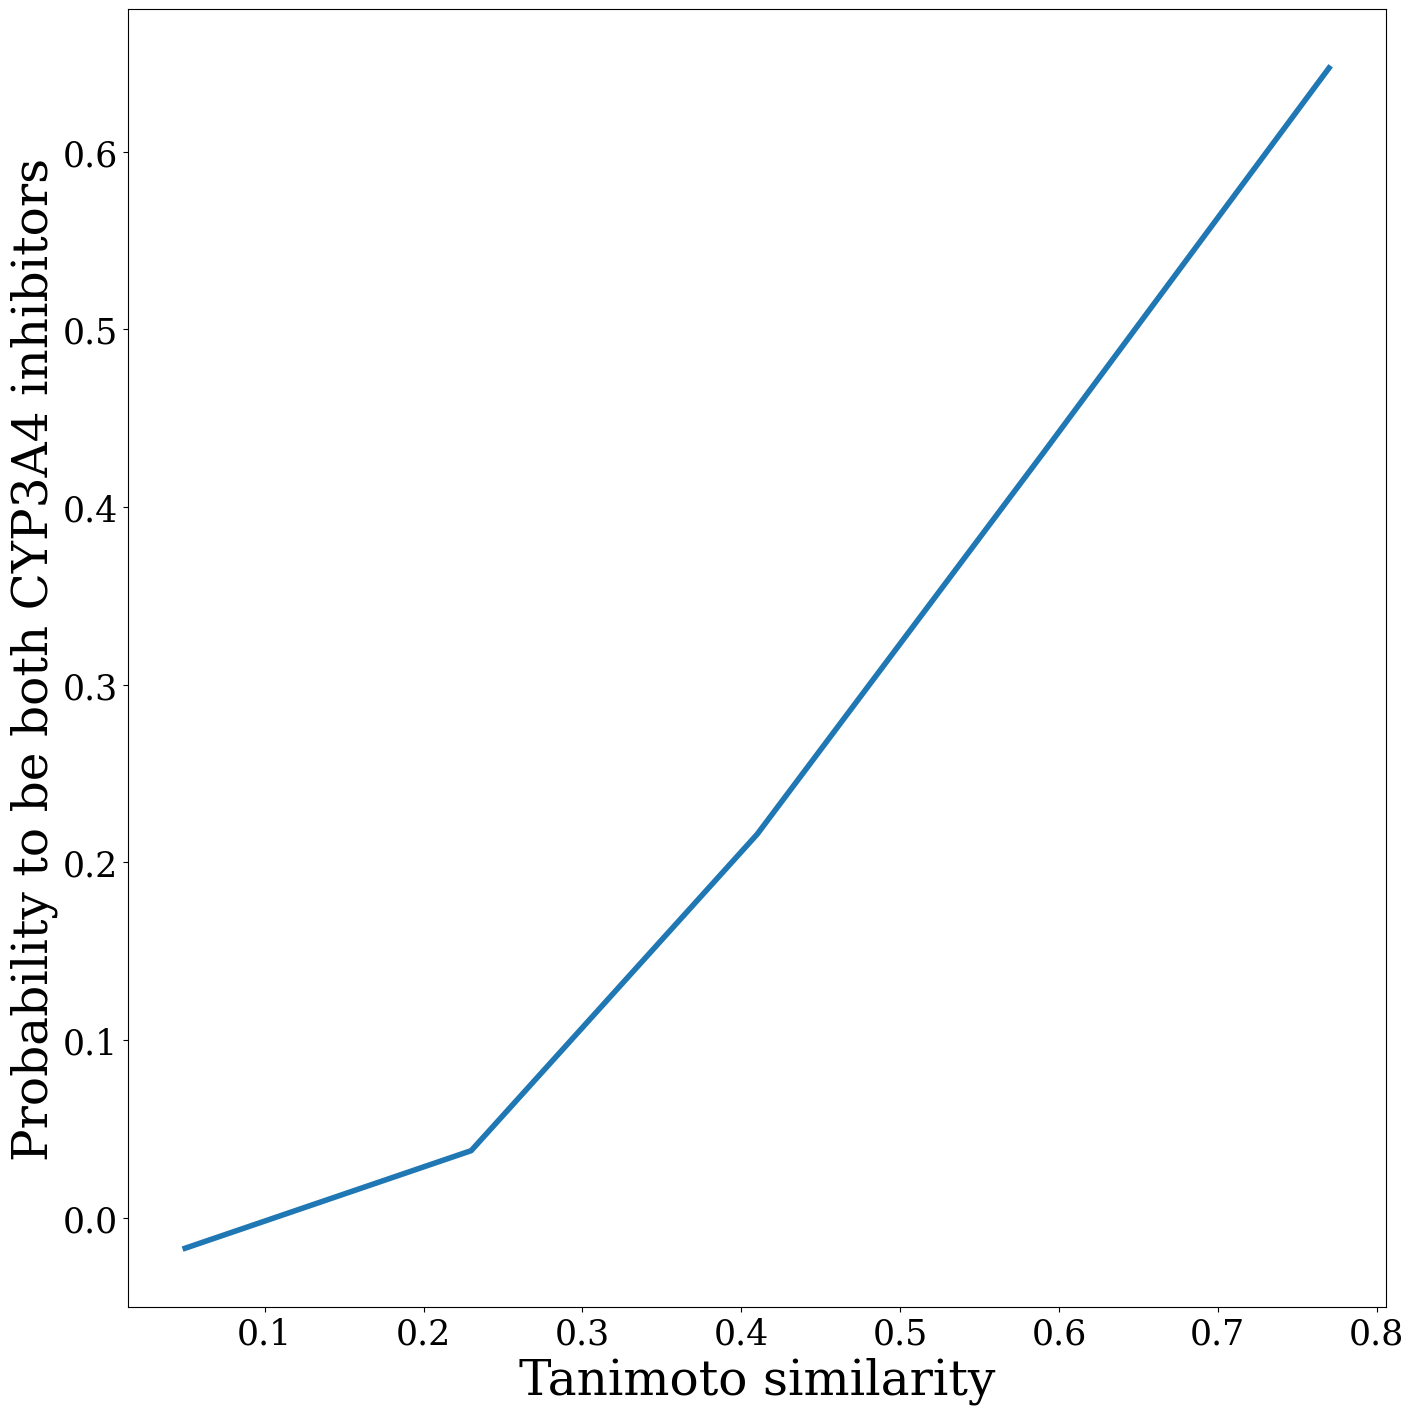

In [26]:
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib as mpl
from matplotlib.patches import Shadow
from matplotlib.lines import Line2D
import numpy as np

font = {'family' : 'normal',
        'size'   : 35}

matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size': 35,
    'pgf.rcfonts': False,
})


matplotlib.rcParams['axes.unicode_minus'] = False

%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(np.linspace(0, 0.9, 6)[:-1] + 0.05, global_probas, linewidth=4)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
ax.set_xlabel("Tanimoto similarity", fontsize=35)
ax.set_ylabel("Probability to be both CYP3A4 inhibitors", fontsize=35)

fig.tight_layout()
plt.savefig('graphs/corr_coeff_cyp3A4.pdf', dpi=300)  
